# Data Science
- Student: Dmytro Geleshko
- Group: IP-91
- Var: 6

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import tensorflow as tf

# Config

In [2]:
# var 6
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option("display.max_columns", None)
pd.options.display.float_format = "{:,.3f}".format

# Load data

In [3]:
df = pd.read_csv("mod_data.csv", index_col="date", parse_dates=True, dtype=np.float32)
df

,close,volume,volume_norm,log_close,log_fit,log_diff,month_sin,month_cos,year_sin,year_cos
date,,,,,,,,,,
2010-07-18,0.100,80.000,-0.674,-2.303,-2.298,-0.005,-0.095,-0.995,-0.266,-0.964
2010-07-19,0.100,570.000,-0.672,-2.303,-2.287,-0.016,-0.297,-0.955,-0.283,-0.959
2010-07-20,0.100,260.000,-0.673,-2.303,-2.276,-0.027,-0.486,-0.874,-0.299,-0.954
2010-07-21,0.100,580.000,-0.672,-2.303,-2.264,-0.038,-0.655,-0.756,-0.316,-0.949
2010-07-22,0.100,"2,160.000",-0.666,-2.303,-2.253,-0.049,-0.796,-0.605,-0.332,-0.943
...,...,...,...,...,...,...,...,...,...,...
2021-11-21,"58,714.301","40,980.000",-0.523,10.980,10.243,0.738,-0.863,-0.505,-0.643,0.766
2021-11-22,"56,308.801","76,450.000",-0.392,10.939,10.244,0.695,-0.948,-0.317,-0.630,0.777
2021-11-23,"57,573.199","72,480.000",-0.406,10.961,10.245,0.716,-0.993,-0.116,-0.616,0.787


In [4]:
df.index.dtype, df.dtypes

(dtype('<M8[ns]'),
 close          float32
 volume         float32
 volume_norm    float32
 log_close      float32
 log_fit        float32
 log_diff       float32
 month_sin      float32
 month_cos      float32
 year_sin       float32
 year_cos       float32
 dtype: object)

In [5]:
features = ["volume_norm", "log_diff", "month_sin", "month_cos", "year_sin", "year_cos"]

# Load coef arrays

In [6]:
log_fit_coef = np.load("saved_params/log_fit_coef.npy")
log_fit_coef

array([[-37.26653031],
       [  5.62681681]])

In [7]:
vol_mean_std = np.load("saved_params/volume_mean_std.npy")
vol_mean, vol_std = vol_mean_std
vol_mean, vol_std

(182627.71029163653, 270991.24624697695)

In [8]:
def get_log_fit(start_i, size, coef):
    F = np.ones((size, 2))
    F[:, 1] = np.log(np.arange(start_i + 500, start_i + 500 + size))
    result = np.dot(F, coef)
    return result.reshape(-1)

# Load & transform new data

In [9]:
url = "https://www.investing.com/crypto/bitcoin/btc-usd-historical-data"

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

dfs = pd.read_html(r.text, attrs = {"id": "curr_table"}, index_col="Date", parse_dates=True)[0]
dfs.columns = dfs.columns.map(lambda x: str.lower(x))

dfs.drop(columns=["open", "high", "low", "change %"], inplace=True)
dfs.rename(columns={"price":"close", "vol.":"volume"}, inplace=True)
dfs.index.name="date"
#sort index
dfs.sort_index(inplace=True)
if dfs.index[-1] > df.index[-1]:
    # if new data is available
    dfs = dfs[df.index[-1]:]

    # cast volume
    _vol = np.ones((dfs.shape[0]), dtype=float)
    for i, vol in enumerate(dfs["volume"]):
        coef = 1
        if vol == "-":
            vol = "0"
        elif "K" in vol:
            coef = 1000
            vol = vol.replace("K", "")
        elif "M" in vol:
            coef = 1000000
            vol = vol.replace("M", "")
        _vol[i] = float(vol) * coef
    
    dfs["volume"] = _vol.astype(np.float32)
    dfs
    # clip & norm volume
    dfs["volume"] = np.clip(dfs["volume"], 0, 1000000)
    dfs["volume_norm"] = (dfs["volume"] - vol_mean) / vol_std
    
    # find log close
    dfs["log_close"] = np.log(dfs["close"].values)
    
    # add lstm fit
    dfs["log_fit"] = get_log_fit(df.shape[0], dfs.shape[0], log_fit_coef)
    dfs["log_diff"] = dfs["log_close"] - dfs["log_fit"]

    # add time features
    day = 24*60*60
    year = (365.2425)*day
    month = year/12
    timestamp_s = dfs.index.map(pd.Timestamp.timestamp)
    dfs["month_sin"] = np.sin(timestamp_s * (2 * np.pi / month))
    dfs["month_cos"] = np.cos(timestamp_s * (2 * np.pi / month))
    dfs["year_sin"] = np.sin(timestamp_s * (2 * np.pi / year))
    dfs["year_cos"] = np.cos(timestamp_s * (2 * np.pi / year))

    dfs = dfs.astype({
        "volume":np.float32,
        "volume_norm":np.float32, 
        "log_fit":np.float32, 
        "log_diff":np.float32,
        "month_sin":np.float32,
        "month_cos":np.float32, 
        "year_sin":np.float32, 
        "year_cos":np.float32})
    df = df.append(dfs)
    df.to_csv("mod_data2.csv")
else:
    print("No new data! Last:")
dfs

,close,volume,volume_norm,log_close,log_fit,log_diff,month_sin,month_cos,year_sin,year_cos
date,,,,,,,,,,
2021-11-25,"58,995.000","3,980.000",-0.659,10.985,10.249,0.737,-0.956,0.292,-0.589,0.808
2021-11-26,"53,738.000","12,190.000",-0.629,10.892,10.250,0.642,-0.876,0.482,-0.575,0.818
2021-11-27,"54,836.000","3,090.000",-0.663,10.912,10.251,0.661,-0.759,0.651,-0.561,0.828
2021-11-28,"57,325.000","4,940.000",-0.656,10.956,10.252,0.704,-0.609,0.793,-0.547,0.837
2021-11-29,"57,845.000","5,070.000",-0.655,10.966,10.253,0.712,-0.434,0.901,-0.532,0.847
2021-11-30,"56,938.000","6,470.000",-0.650,10.950,10.255,0.695,-0.240,0.971,-0.517,0.856
2021-12-01,"58,666.000","4,520.000",-0.657,10.980,10.256,0.724,-0.036,0.999,-0.503,0.865


In [10]:
df

,close,volume,volume_norm,log_close,log_fit,log_diff,month_sin,month_cos,year_sin,year_cos
date,,,,,,,,,,
2010-07-18,0.100,80.000,-0.674,-2.303,-2.298,-0.005,-0.095,-0.995,-0.266,-0.964
2010-07-19,0.100,570.000,-0.672,-2.303,-2.287,-0.016,-0.297,-0.955,-0.283,-0.959
2010-07-20,0.100,260.000,-0.673,-2.303,-2.276,-0.027,-0.486,-0.874,-0.299,-0.954
2010-07-21,0.100,580.000,-0.672,-2.303,-2.264,-0.038,-0.655,-0.756,-0.316,-0.949
2010-07-22,0.100,"2,160.000",-0.666,-2.303,-2.253,-0.049,-0.796,-0.605,-0.332,-0.943
...,...,...,...,...,...,...,...,...,...,...
2021-11-27,"54,836.000","3,090.000",-0.663,10.912,10.251,0.661,-0.759,0.651,-0.561,0.828
2021-11-28,"57,325.000","4,940.000",-0.656,10.956,10.252,0.704,-0.609,0.793,-0.547,0.837
2021-11-29,"57,845.000","5,070.000",-0.655,10.966,10.253,0.712,-0.434,0.901,-0.532,0.847


# Load Model

In [11]:
model = tf.keras.models.load_model("saved_model/v2.h5")

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 42)                8232      
                                                                 
 dense (Dense)               (None, 7)                 301       
                                                                 
Total params: 8,533
Trainable params: 8,533
Non-trainable params: 0
_________________________________________________________________


In [12]:
def get_forecast(df, features, model, coef):
    # vals
    x = df[features].iloc[-21:].values.reshape((1, 21, 6))
    y = model.predict(x)[0]
    
    #dates
    dates_x = pd.date_range(df.index[-21], periods=28, freq="D")
    dates_y = dates_x[-7:]
    dates_x = dates_x[:-7]

    # convert X
    x = np.exp(df["log_diff"].iloc[-21:].values + df["log_fit"].iloc[-21:].values)
    
    # convert y def 
    y = np.exp(y + get_log_fit(df.shape[0], size=7, coef=coef))
    
    #plot
    plt.plot(dates_x, x, label="history", color="blue")
    plt.plot(dates_y, y, label="forecast", color="red")
    plt.plot([dates_x[-1], dates_y[0]], [x[-1], y[0]], color="red", linestyle="--")
    plt.legend()
    plt.plot()

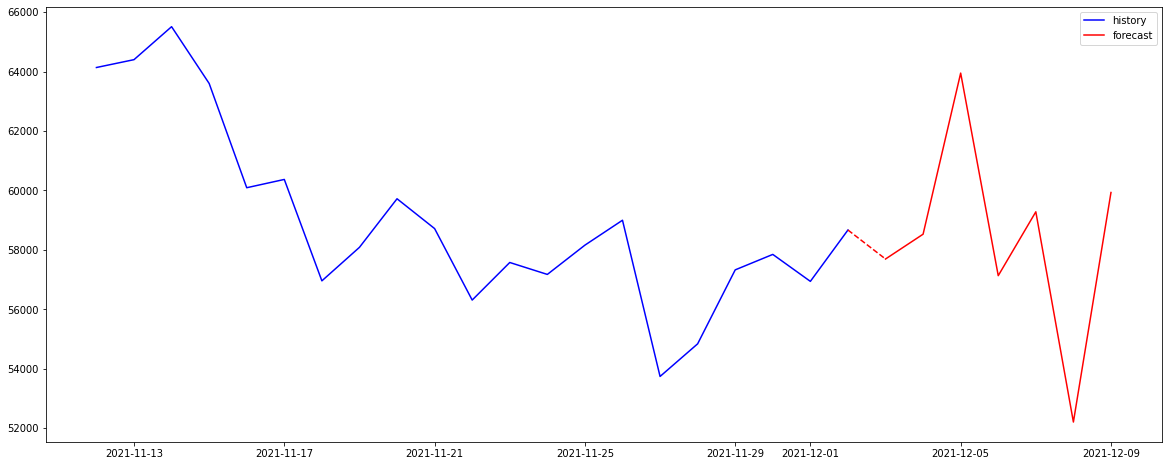

In [13]:
get_forecast(df, features, model, log_fit_coef)